# Duplicates Detection Method

In [3]:
### IMPORT PACKAGES

import sys
import pandas as pd
import numpy as np
import json
import kshingle as ks
import random 
import string
import re
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import itertools
import math
import tqdm
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize)

### 1.1 Load Data

In [4]:
# Open JSON file
with open('TVs-all-merged.json') as f:
  data = json.load(f)

print(type(data))

print(len(data.keys()))

<class 'dict'>
1262


### 2.1 Define all functions

In [10]:
# Function for number of product descriptions
def total_products(data):
    total_products = 0
    for key in data.keys():
        total_products += len(data[key]) 
    print(total_products)

# Split descriptions to make separate dictionary
def get_product_dicts(data):
    product_dicts = {}
    i=0
    for key in data.keys():
        for product in data[key]:
            product_dicts[i] = product
            i += 1
    return product_dicts

# Remove type of description and 
def get_products(product_dicts):
    products = {}
    i = 0
    for key in product_dicts.keys():
        products[i] = []
        for description in product_dicts[key]:
            if description == 'title' :
                products[i].append(product_dicts[key][description])
            elif description == 'featuresMap':
                for feature in product_dicts[key][description].keys():
                    products[i].append(product_dicts[key][description][feature])
        i += 1
    return products

# Get all titles for bootstrapping
def get_titles(products):
    titles = []
    for product in products:
        titles.append(products[product]["title"])
    return titles

# Bootstrap function
def create_bootstraps(b, products):    
    train_set = []
    test_set = []
    for i in range(b):
        boot = random.choices(range(len(products)), k=len(products))
        boot_noDuplicates = list(set(boot))
        complete = list(range(len(boot)))
        train_set.append(sorted(boot))
        test = list(set(complete) - set(train_set[i]))
        test_set.append(test)
    return train_set, test_set, boot_noDuplicates


# Extract model words title from key-value pairs
def extract_mw(products):
    model_words = []
    for key in products.keys():
        title_mw = ["".join(x[0]) for x in re.findall(r'([a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*)', products[key][-1])]
        for subitem in title_mw:
            if subitem is not None and subitem not in model_words:
                model_words.append(subitem)
        for item in products[key][:-1]:
            keyvalue_mw = re.findall(r'(ˆ\d+(\.\d+)?[a-zA-Z]+$|ˆ\d+(\.\d+)?$)', item)
            if keyvalue_mw is not None and keyvalue_mw not in model_words:
                model_words.append(keyvalue_mw)
    for mw in model_words:
        if not isinstance(mw, str):
            model_words.remove(mw)
    return model_words

# Count occurrence of a string in whole dictionary
def occurrence_counter(products, string):
    count = 0
    for key in products.keys():
        for item in products[key]:
            count += item.count(string)
    print(count)

# Data cleaning
def clean_data(products_raw):
    products = {}
    for key in products_raw.keys():
        products[key] = []
        for item in products_raw[key]:
            item = item.replace('"', 'inch').replace('-inch', 'inch').replace('inches', 'inch').replace(' inch', 'inch').replace('inch', 'inch')
            item = item.replace('Hertz', 'hz').replace('hertz', 'hz').replace('Hz', 'hz').replace('HZ', 'hz').replace('-hz', 'hz').replace('hz', 'hz')
            products[key].append(item)
    return products

# Create binary matrix
def get_bin_matrix(products, model_words):    
    binary_matrix = None
    i = 0
    for product in products:
        bin_list = []
        for mw in model_words:
            if any(mw in item for item in products[product]):
                bin_list.append(1)
            else:
                bin_list.append(0) 
        bin_vec = np.array(bin_list)
        if i == 0:
            binary_matrix = bin_vec # Initialize matrix
        else:
            binary_matrix = np.c_[binary_matrix, bin_vec] # Append column for product i
        i += 1
    return binary_matrix

# Generate random prime number
def primeNumbers(a,b):
    list_of_primes = []
    for n in range(a,b):
        isPrimeNumber = True
        for number in range(2,n):
            if n % number == 0:
                isPrimeNumber == False
        if isPrimeNumber == True:
            list_of_primes.append(n)
    return list_of_primes

# Gernerate hash functions
def hash_funcs(model_words, binary_matrix):
    n = round(len(model_words)/2) # Number of hash functions equal to half of the model words 
    primes = primeNumbers(n, n + 200)
    p = random.choice(primes)
    a = []
    b = []
    for i in range(0,n):
        a.append(random.randint(0, len(model_words)))
        b.append(random.randint(1,len(model_words)))
    hash_func_values = [[0 for i in range(len(binary_matrix))] for j in range(n)]
    for j in range(0, len(a)):
        for i in range(0, len(binary_matrix)):
            hash_func_values[j][i] = (a[j]+b[j]*i)%p
    return hash_func_values

# Create Signature Matrix
def MinHash(binary_matrix, model_words, products, hash_func_values):
    columns = list(range(len(binary_matrix)))
    binary_matrix_pd = pd.DataFrame(binary_matrix, columns)
    transposed_binary_matrix = binary_matrix_pd.transpose() # Slide 40 of LSH lecture, sort matrix to compute hashed values once for each row
    n = round(len(model_words)/2)
    sig = [float('inf')]*n 
    signatures = [sig]*(len(transposed_binary_matrix))
    signatures = np.matrix(signatures)

    for i in range(len(transposed_binary_matrix)): # rows, represent product descriptions
        for j in range(len(binary_matrix_pd)): # columns, represent model words
            if transposed_binary_matrix.iloc[i,j] == 1: # Check the permutations
                for other in range(len(hash_func_values)): # Check for other hashed values
                    if hash_func_values[other][j] < signatures[i,other]: # value per hash
                        signatures[i,other] = hash_func_values[other][j]

    signatures = np.transpose(signatures)
    signatures = signatures.astype(int)
    #signatures = pd.DataFrame(signatures, index=products.keys())
    #signatures.columns = np.arange(1, n+1)
    
    return signatures

# Create LSH function
def LSH(signature_matrix, products, model_words, r):

    signature_matrix = pd.DataFrame(signature_matrix)
    blength = r  # r in LSH method
    n = round(len(model_words)/2)
    total_bands = int(n/blength) # b in LSH
    sigband = []

    if type(total_bands) is not int:
        raise Exception("Number of bands is not integer-valued. Input other band length.")

    # Get the signatures per band in a list
    for i in range(1, total_bands+1):
        if i == 1:
            sigband.append(signature_matrix.iloc[0:blength])
        else:
            sigband.append(signature_matrix.iloc[blength*(i-1):blength*i])

    # Make matrix with 'rows in a band for one column' combined as elements
    bands_to_be_combined = np.zeros((len(sigband), len(products)))
    band_matrix = pd.DataFrame(bands_to_be_combined, columns=products.keys())

    value = ""    
    for band in range(len(sigband)):
        for j in range(len(sigband[0].iloc[0,:])):
            for i in range(len(sigband[0])):
                value += str(sigband[band].iloc[i,j])
            band_matrix.iloc[band,j] = value
            value = ""
   
    # Create empty candidate matrix
    candidates = np.zeros((len(products),len(products)))
    candidates = pd.DataFrame(candidates).astype(int)

    # All candidates put in matrix of candidate-pairs
    for i in range(len(band_matrix)): # For each of the 74 bands
        values_per_band = band_matrix.iloc[i,:]
        #values_per_band = values_per_band.to_numpy()
        txt = "Type of values per band is {type}"
        #print(txt.format(type = type(values_per_band)))
        #values_per_band = np.sort(np.int64(values_per_band)) # Sort the values from small to large
        values_per_band = values_per_band.sort_values()
       
        major = [] # final buckets
        minor = [] # temporary buckets per band
    
        try:
            for j in range(len(values_per_band)-1): #range(len(values_per_band)-1): # For each product
                if j == len(values_per_band)-2:
                    minor.append(j)
                    minor.append(j+1)
                    major.append(minor)
                elif values_per_band[j+1] == values_per_band[j]:
                    minor.append(j)
                else:
                    minor.append(j)
                    major.append(minor)
                    minor.clear()
        except KeyError:
            pass
        
        combinations = []
        for x in range(len(major)):
            for subset in itertools.combinations(major[x], 2): # Check the possible candidates
                combinations.append(tuple(subset))
               
        for comb in range(len(combinations)):
            candidates[int(combinations[comb][0])][int(combinations[comb][1])] = 1
            candidates[int(combinations[comb][1])][int(combinations[comb][0])] = 1
           
    # Convert candidates to lower triangular
    arr_candidates = candidates.to_numpy()
    candidate_matrix = np.tril(arr_candidates)

    return candidate_matrix

# Get number of comparisons
def number_of_comparisons(candidate_matrix):
    number_of_comparisons = np.sum(candidate_matrix)
    
    return number_of_comparisons 

# Function for total number of comparisons
def total_possible_comparisons(candidate_matrix):
    ones_lower = np.tril(np.ones((len(candidate_matrix),len(candidate_matrix))))
    np.fill_diagonal(ones_lower, 0)
    total_possible = np.sum(ones_lower)
    
    return total_possible

# Function for Pair Quality
def pairquality(duplicates_found, num_of_comp):
    pq = duplicates_found / num_of_comp

    return pq

# Function for Pair Completeness
def paircompleteness(duplicates_found, total_real_duplicates):
    pc = duplicates_found / total_real_duplicates

    return pc

# Function for F1*
def F1star(pq, pc):
    F1star_score = (pq + pc)/2

    return F1star_score

# Function for F1
def F1(TP, FP, TN, FN):
    precision = (TP+1) / (TP+1 + FP)
    recall = (TP+1) / (TP+1 + FN)
    F1 = (2*precision*recall)/(precision+recall)

    return F1

# Function for fraction of comparisons
def frac_of_comparisons(num_of_comp, total_possible):
    frac = num_of_comp/total_possible

    return frac
    
# Function to check all real duplicates and also returns total 
def realduplicates(product_dicts):
    real_duplicate_matrix = np.zeros((len(product_dicts.keys()), len(product_dicts.keys())))
    #real_duplicate_matrix = pd.DataFrame(real_duplicate_matrix)

    for product_i in product_dicts.keys():
        for product_j in product_dicts.keys():
            if product_dicts[product_i]['modelID'] == product_dicts[product_j]['modelID']:
                if product_i != product_j:
                    real_duplicate_matrix[product_i, product_j] = 1
    
    total_realduplicates = np.sum(real_duplicate_matrix)/2
    real_duplicate_matrix = real_duplicate_matrix.astype(int)

    return real_duplicate_matrix, total_realduplicates

# Candidate evaluation
def evaluate_candidates(candidate_matrix, real_duplicate_matrix, products, binary_matrix, t):
    detected_duplicates_J = np.zeros((len(candidate_matrix),len(candidate_matrix)))
    detected_duplicates_C = np.zeros((len(candidate_matrix),len(candidate_matrix)))
    
    for i in range(len(candidate_matrix)):
        for j in range(len(candidate_matrix)):
            if candidate_matrix[i,j] == 1:
                title1 = products[list(products.keys())[i]][-1]
                title2 = products[list(products.keys())[j]][-1]
                comp = [title1,title2]
                vectorizer = CountVectorizer().fit_transform(comp)
                vectors = vectorizer.toarray()
                if detected_duplicates_J[i,j] == 0:
                    detected_duplicates_J[i,j] = (1 if jaccard_score(binary_matrix[:,i], binary_matrix[:,j], average='micro') >= t else 0)
                if detected_duplicates_C[i,j] == 0:
                    detected_duplicates_C[i,j] = (1 if cosine_similarity(vectors)[0,1] >= t else 0)
    FN_c = 0
    FP_c = 0
    TN_c = 0
    TP_c = 0
    FN_j = 0
    FP_j = 0
    TN_j = 0
    TP_j = 0
    
    detected_duplicates_C  = detected_duplicates_C.astype(int)
    detected_duplicates_J = detected_duplicates_J.astype(int)

    for i in range(len(detected_duplicates_C)):
        for j in range(len(detected_duplicates_C)):
            if detected_duplicates_C[i,j] == 0 and real_duplicate_matrix[i,j] == 0:
                TN_c += 1
            elif detected_duplicates_C[i,j] == 1 and real_duplicate_matrix[i,j] == 0:
                FP_c += 1
            elif detected_duplicates_C[i,j] == 0 and real_duplicate_matrix[i,j] == 1:
                FN_c += 1
            elif detected_duplicates_C[i,j] == 1 and real_duplicate_matrix[i,j] == 1:
                TP_c += 1

    for i in range(len(detected_duplicates_J)):
        for j in range(len(detected_duplicates_J)):
            if detected_duplicates_J[i,j] == 0 and real_duplicate_matrix[i,j] == 0:
                TN_j += 1
            elif detected_duplicates_J[i,j] == 1 and real_duplicate_matrix[i,j] == 0:
                FP_j += 1
            elif detected_duplicates_J[i,j] == 0 and real_duplicate_matrix[i,j] == 1:
                FN_j += 1
            elif detected_duplicates_J[i,j] == 1 and real_duplicate_matrix[i,j] == 1:
                TP_j += 1

    return TP_c, TN_c, FP_c, FN_c, TP_j, TN_j, FP_j, FN_j




### 2.2 Duplicate Detection Model

In [6]:
def full_detection_model(products, product_dicts, rows, threshold):    
    t = threshold
    r = rows
    model_words = extract_mw(products)

    binary_matrix = get_bin_matrix(products, model_words)
    
    hash_func_values = hash_funcs(model_words, binary_matrix)

    signature_matrix = MinHash(binary_matrix, model_words, products, hash_func_values)

    candidate_matrix = LSH(signature_matrix, products, model_words, r)

    real_duplicate_matrix, total_realdup = realduplicates(product_dicts)

    TP_c, TN_c, FP_c, FN_c, TP_j, TN_j, FP_j, FN_j = evaluate_candidates(candidate_matrix, real_duplicate_matrix, products, binary_matrix, t)

    F1j = F1(TP=TP_j, FP=FP_j, TN=TN_j, FN=FN_j)
    F1c = F1(TP=TP_c, FP=FP_c, TN=TN_c, FN=FN_c)
    num_of_comp = number_of_comparisons(candidate_matrix)
    total_possible_comp = total_possible_comparisons(candidate_matrix)
    fraction = frac_of_comparisons(num_of_comp, total_possible_comp)
    pq_c = pairquality(TP_c, num_of_comp)
    pq_j = pairquality(TP_j, num_of_comp)
    pc_c = paircompleteness(TP_c, total_realdup)
    pc_j = paircompleteness(TP_j, total_realdup)

    F1j = F1(TP=TP_j, FP=FP_j, TN=TN_j, FN=FN_j)
    F1c = F1(TP=TP_c, FP=FP_c, TN=TN_c, FN=FN_c)
    F1star_c = F1star(pq_c, pc_c)
    F1star_j = F1star(pq_j, pc_j)

    return fraction, F1c, F1j, F1star_c, F1star_j





### For each bootstrap

In [ ]:
product_dicts = get_product_dicts(data)

products_raw = get_products(product_dicts)

products = clean_data(products_raw)
num_of_bootstraps = 5
train_set, test_set, boot_noDuplicates = create_bootstraps(num_of_bootstraps, products)

outcomes3 = []
for j in range(num_of_bootstraps):
    products_boot = {}
    for index in test_set[j]:
        products_boot.update({index : products[index]})
    outcome = full_detection_model(products_boot, product_dicts, rows=3, threshold=0.2)
    outcomes3.append(outcome)

frac_avg3 = (outcomes3[0][0]+outcomes3[1][0]+outcomes3[2][0]+outcomes3[3][0]+outcomes3[4][0])/5
F1c_avg3 = (outcomes3[0][1]+outcomes3[1][1]+outcomes3[2][1]+outcomes3[3][1]+outcomes3[4][1])/5
F1j_avg3 = (outcomes3[0][2]+outcomes3[1][2]+outcomes3[2][2]+outcomes3[3][2]+outcomes3[4][2])/5
F1star_c_avg3 = (outcomes3[0][3]+outcomes3[1][3]+outcomes3[2][3]+outcomes3[3][3]+outcomes3[4][3])/5
F1star_j_avg3 = (outcomes3[0][4]+outcomes3[1][4]+outcomes3[2][4]+outcomes3[3][4]+outcomes3[4][4])/5

outcomes6 = []
for j in range(num_of_bootstraps):
    products_boot = {}
    for index in test_set[j]:
        products_boot.update({index : products[index]})
    outcome = full_detection_model(products_boot, product_dicts, rows=6, threshold=0.2)
    outcomes6.append(outcome)

frac_avg6 = (outcomes6[0][0]+outcomes6[1][0]+outcomes6[2][0]+outcomes6[3][0]+outcomes6[4][0])/5
F1c_avg6 = (outcomes6[0][1]+outcomes6[1][1]+outcomes6[2][1]+outcomes6[3][1]+outcomes6[4][1])/5
F1j_avg6 = (outcomes6[0][2]+outcomes6[1][2]+outcomes6[2][2]+outcomes6[3][2]+outcomes6[4][2])/5
F1star_c_avg6 = (outcomes6[0][3]+outcomes6[1][3]+outcomes6[2][3]+outcomes6[3][3]+outcomes6[4][3])/5
F1star_j_avg6 = (outcomes6[0][4]+outcomes6[1][4]+outcomes6[2][4]+outcomes6[3][4]+outcomes6[4][4])/5

outcomes9 = []
for j in range(num_of_bootstraps):
    products_boot = {}
    for index in test_set[j]:
        products_boot.update({index : products[index]})
    outcome = full_detection_model(products_boot, product_dicts, rows=9, threshold=0.2)
    outcomes9.append(outcome)

frac_avg9 = (outcomes9[0][0]+outcomes9[1][0]+outcomes9[2][0]+outcomes9[3][0]+outcomes9[4][0])/5
F1c_avg9 = (outcomes9[0][1]+outcomes9[1][1]+outcomes9[2][1]+outcomes9[3][1]+outcomes9[4][1])/5
F1j_avg9 = (outcomes9[0][2]+outcomes9[1][2]+outcomes9[2][2]+outcomes9[3][2]+outcomes9[4][2])/5
F1star_c_avg9 = (outcomes9[0][3]+outcomes9[1][3]+outcomes9[2][3]+outcomes9[3][3]+outcomes9[4][3])/5
F1star_j_avg9 = (outcomes9[0][4]+outcomes9[1][4]+outcomes9[2][4]+outcomes9[3][4]+outcomes9[4][4])/5

outcomes18 = []
for j in range(num_of_bootstraps):
    products_boot = {}
    for index in test_set[j]:
        products_boot.update({index : products[index]})
    outcome = full_detection_model(products_boot, product_dicts, rows=18, threshold=0.2)
    outcomes18.append(outcome)

frac_avg18 = (outcomes18[0][0]+outcomes18[1][0]+outcomes18[2][0]+outcomes18[3][0]+outcomes18[4][0])/5
F1c_avg18 = (outcomes18[0][1]+outcomes18[1][1]+outcomes18[2][1]+outcomes18[3][1]+outcomes18[4][1])/5
F1j_avg18 = (outcomes18[0][2]+outcomes18[1][2]+outcomes18[2][2]+outcomes18[3][2]+outcomes18[4][2])/5
F1star_c_avg18 = (outcomes18[0][3]+outcomes18[1][3]+outcomes18[2][3]+outcomes18[3][3]+outcomes18[4][3])/5
F1star_j_avg18 = (outcomes18[0][4]+outcomes18[1][4]+outcomes18[2][4]+outcomes18[3][4]+outcomes18[4][4])/5




In [6]:
f1c = [F1c_avg3,F1c_avg6,F1c_avg9,F1c_avg18]
f1j = [F1j_avg3, F1j_avg6, F1j_avg9, F1j_avg18]
f1starc = [F1star_c_avg3, F1star_c_avg6, F1star_c_avg9, F1star_c_avg18]
f1starj = [F1star_j_avg3, F1star_j_avg6, F1star_j_avg9, F1star_j_avg18]
fracs = [frac_avg3, frac_avg6, frac_avg9, frac_avg18]


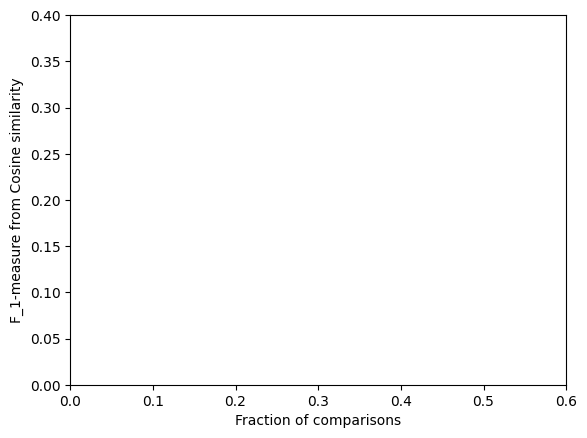

In [15]:
plt.plot(fracs, f1c)
plt.xlabel('Fraction of comparisons')
plt.ylabel('F_1-measure from Cosine similarity')
plt.xlim(0,0.6)
plt.ylim(0,0.4)
plt.savefig('figuref1c.png')


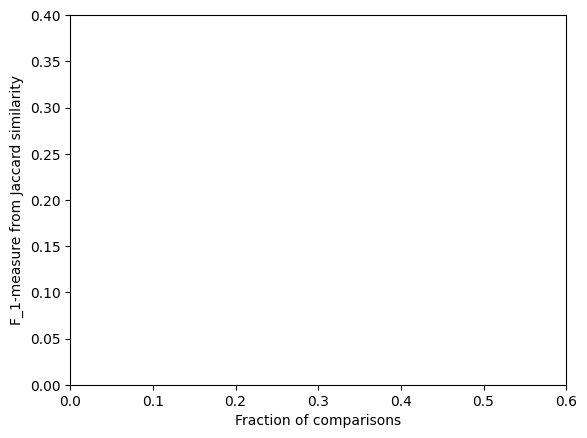

In [14]:
plt.plot(fracs, f1j)
plt.xlabel('Fraction of comparisons')
plt.ylabel('F_1-measure from Jaccard similarity')
plt.xlim(0,0.6)
plt.ylim(0,0.4)
plt.savefig('figuref1j.png')


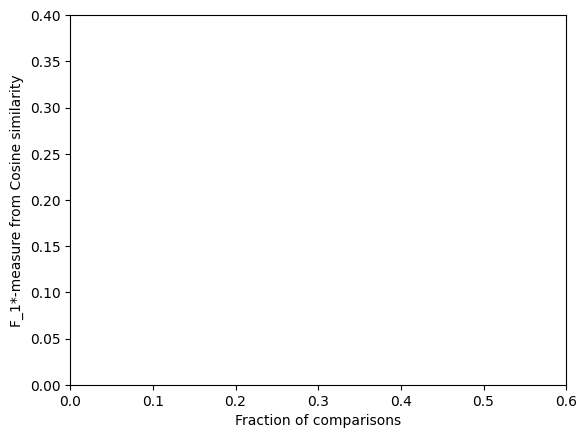

In [13]:
plt.plot(fracs, f1starc)
plt.xlabel('Fraction of comparisons')
plt.ylabel('F_1*-measure from Cosine similarity')
plt.xlim(0,0.6)
plt.ylim(0,0.4)
plt.savefig('figuref1cstar.png')

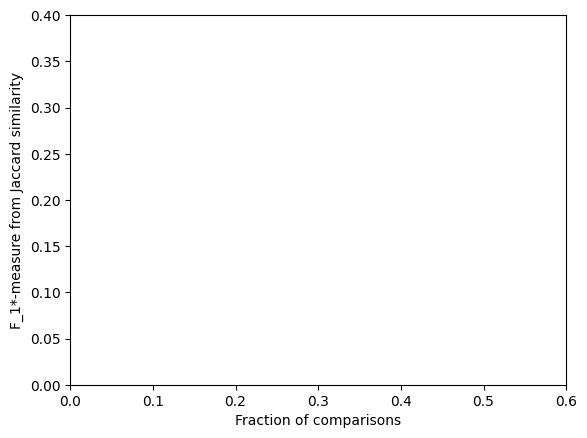

In [11]:
plt.plot(fracs, f1starj)
plt.xlabel('Fraction of comparisons')
plt.ylabel('F_1*-measure from Jaccard similarity')
plt.xlim(0,0.6)
plt.ylim(0,0.4)
plt.savefig('figuref1jstar.png')